In [12]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

my_seed = 146
random.seed(my_seed)
np.random.seed(my_seed)

## Анализ данных

In [4]:
data = pd.read_csv('data-55.csv', index_col=['time'])
data.index = pd.to_datetime(data.index, format='%Y-%m-%d %H:%M')

In [5]:
data.head()

,Regular insulin dose,NPH insulin dose,UltraLente insulin dose,Unspecified blood glucose measurement,Unspecified blood glucose measurement.1,Pre-breakfast blood glucose measurement,Post-breakfast blood glucose measurement,Pre-lunch blood glucose measurement,Post-lunch blood glucose measurement,Pre-supper blood glucose measurement,Post-supper blood glucose measurement,Pre-snack blood glucose measurement,Hypoglycemic symptoms,Typical meal ingestion,More-than-usual meal ingestion,Less-than-usual meal ingestion,Typical exercise activity,More-than-usual exercise activity,Less-than-usual exercise activity,Unspecified special event
time,,,,,,,,,,,,,,,,,,,,
1991-03-01 08:00:00,7,22,0,0,0,281,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1991-03-01 12:00:00,0,0,0,0,0,0,0,209,0,0,0,0,0,0,0,0,0,0,0,0
1991-03-01 18:00:00,10,10,0,0,0,0,0,0,0,116,0,0,0,0,0,0,0,0,0,0
1991-03-01 22:00:00,0,0,0,321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1991-03-02 08:00:00,7,22,0,0,0,304,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Удалим все лишние столбцы (заполненные нулями)

In [5]:
data = data.loc[:, (data != 0).any(axis=0)]
data.columns

Index(['Regular insulin dose', 'NPH insulin dose', 'UltraLente insulin dose',
       'Unspecified blood glucose measurement',
       'Unspecified blood glucose measurement.1',
       'Pre-breakfast blood glucose measurement',
       'Pre-lunch blood glucose measurement',
       'Pre-supper blood glucose measurement'],
      dtype='object')

Суммируем инсулин и глюкозу в каждый час измерений

In [6]:
df = pd.DataFrame()
df.index = data.index
df['insulin'] = data['Regular insulin dose'] + data['NPH insulin dose'] + data['UltraLente insulin dose']
df['glucose'] = data.drop(['Regular insulin dose', 'NPH insulin dose', 'UltraLente insulin dose'], axis=1).sum(axis=1)

In [8]:
df.head()

,insulin,glucose
time,,
1991-03-01 08:00:00,29,281
1991-03-01 12:00:00,0,209
1991-03-01 18:00:00,20,116
1991-03-01 22:00:00,0,321
1991-03-02 08:00:00,29,304


Задаем частоту и заполняем пропуски/

In [7]:
df = df.asfreq('H')
df.head()

,insulin,glucose
time,,
1991-03-01 08:00:00,29.0,281.0
1991-03-01 09:00:00,NaN,NaN
1991-03-01 10:00:00,NaN,NaN
1991-03-01 11:00:00,NaN,NaN
1991-03-01 12:00:00,0.0,209.0


In [8]:
df['glucose'].interpolate(method='linear', inplace=True)
df['insulin'].fillna(0, inplace=True)

In [11]:
df.head()

,insulin,glucose
time,,
1991-03-01 08:00:00,29.0,281.0
1991-03-01 09:00:00,0.0,263.0
1991-03-01 10:00:00,0.0,245.0
1991-03-01 11:00:00,0.0,227.0
1991-03-01 12:00:00,0.0,209.0


Смотрим на получившиеся данные

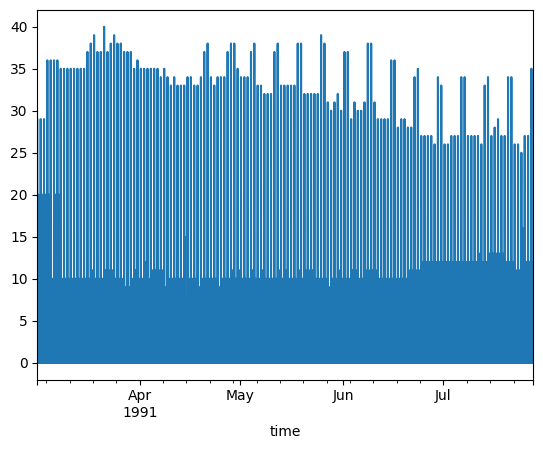

In [13]:
df['insulin'].plot()
plt.show()

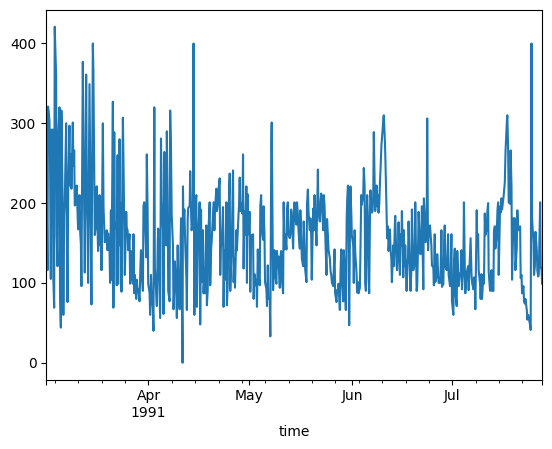

In [14]:
df['glucose'].plot()
plt.show()

In [9]:
data = df.copy()

#### Тест Дики-Фуллера

In [10]:
alpha = 0.05

for column in tqdm(data.columns):
    name = column
    ts = data[column]

    print(f'Тест Дики-Фуллера ряда {name}:')
    try:
        dftest = adfuller(ts, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

        for key, value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)

        if dfoutput["p-value"] < alpha:
            print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
        else:
            print(f"Значение p больше {alpha * 100}%. Ряд не стационарный.")

    except Exception as e:
        print(f"Ряд постоянный => он не стационарный")

    print('\n')

  0%|          | 0/2 [00:00<?, ?it/s]

Тест Дики-Фуллера ряда insulin:


 50%|█████     | 1/2 [00:00<00:00,  2.57it/s]

Test Statistic                -7.523969e+00
p-value                        3.726848e-11
#Lags Used                     2.900000e+01
Number of Observations Used    3.537000e+03
Critical Value (1%)           -3.432200e+00
Critical Value (5%)           -2.862358e+00
Critical Value (10%)          -2.567205e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


Тест Дики-Фуллера ряда glucose:


100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

Test Statistic                -6.116237e+00
p-value                        9.080446e-08
#Lags Used                     3.000000e+01
Number of Observations Used    3.536000e+03
Critical Value (1%)           -3.432201e+00
Critical Value (5%)           -2.862358e+00
Critical Value (10%)          -2.567205e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


#### Тест Йохансена

In [11]:
print(*coint_johansen(data, -1, 1).eig)

0.4024252876101281 0.010646640365158938


Значения по модулю меньше единицы, значит ряд стационарен

#### Тест на коинтегральность

In [15]:
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
insulin ::  731.85    > 12.3212   =>   True
glucose ::  17.22     > 4.1296    =>   True


In [17]:
df = data.copy()

#### Разделение на train и test

In [18]:
df_train = df[:int(len(df)*0.9)]
df_test = df[int(len(df)*0.9):len(df)]

In [19]:
def calculate_smape(actual_, predicted_):
    actual = predicted_.to_numpy()
    predicted = actual_.to_numpy()
    return round(np.mean(np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted) + 1e-15)), 10)

## Построение моделей

### Классические модели

#### VAR

In [20]:
max_p = 512
model = VAR(df_train)

best_p = model.select_order(maxlags=max_p).selected_orders['aic']

print("Optimal p:", best_p)

Optimal p: 194


In [21]:
model_fitted = model.fit(best_p, ic='aic')
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 14, Jan, 2024
Time:                     19:46:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.11407
Nobs:                     3016.00    HQIC:                   3.12096
Log likelihood:          -11646.5    FPE:                    13.0162
AIC:                      2.56331    Det(Omega_mle):         10.2121
--------------------------------------------------------------------
Results for equation insulin
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                1.209174         0.465606            2.597           0.009
L1.insulin          -0.038630         0.019568           -1.974           0.048
L1.glucose           0.006887         0.001354            5.08

In [22]:
forecast = model_fitted.forecast(y=model_fitted.endog, steps=len(df_test))
forecast = pd.DataFrame(forecast, columns=[col for col in df_train.columns])

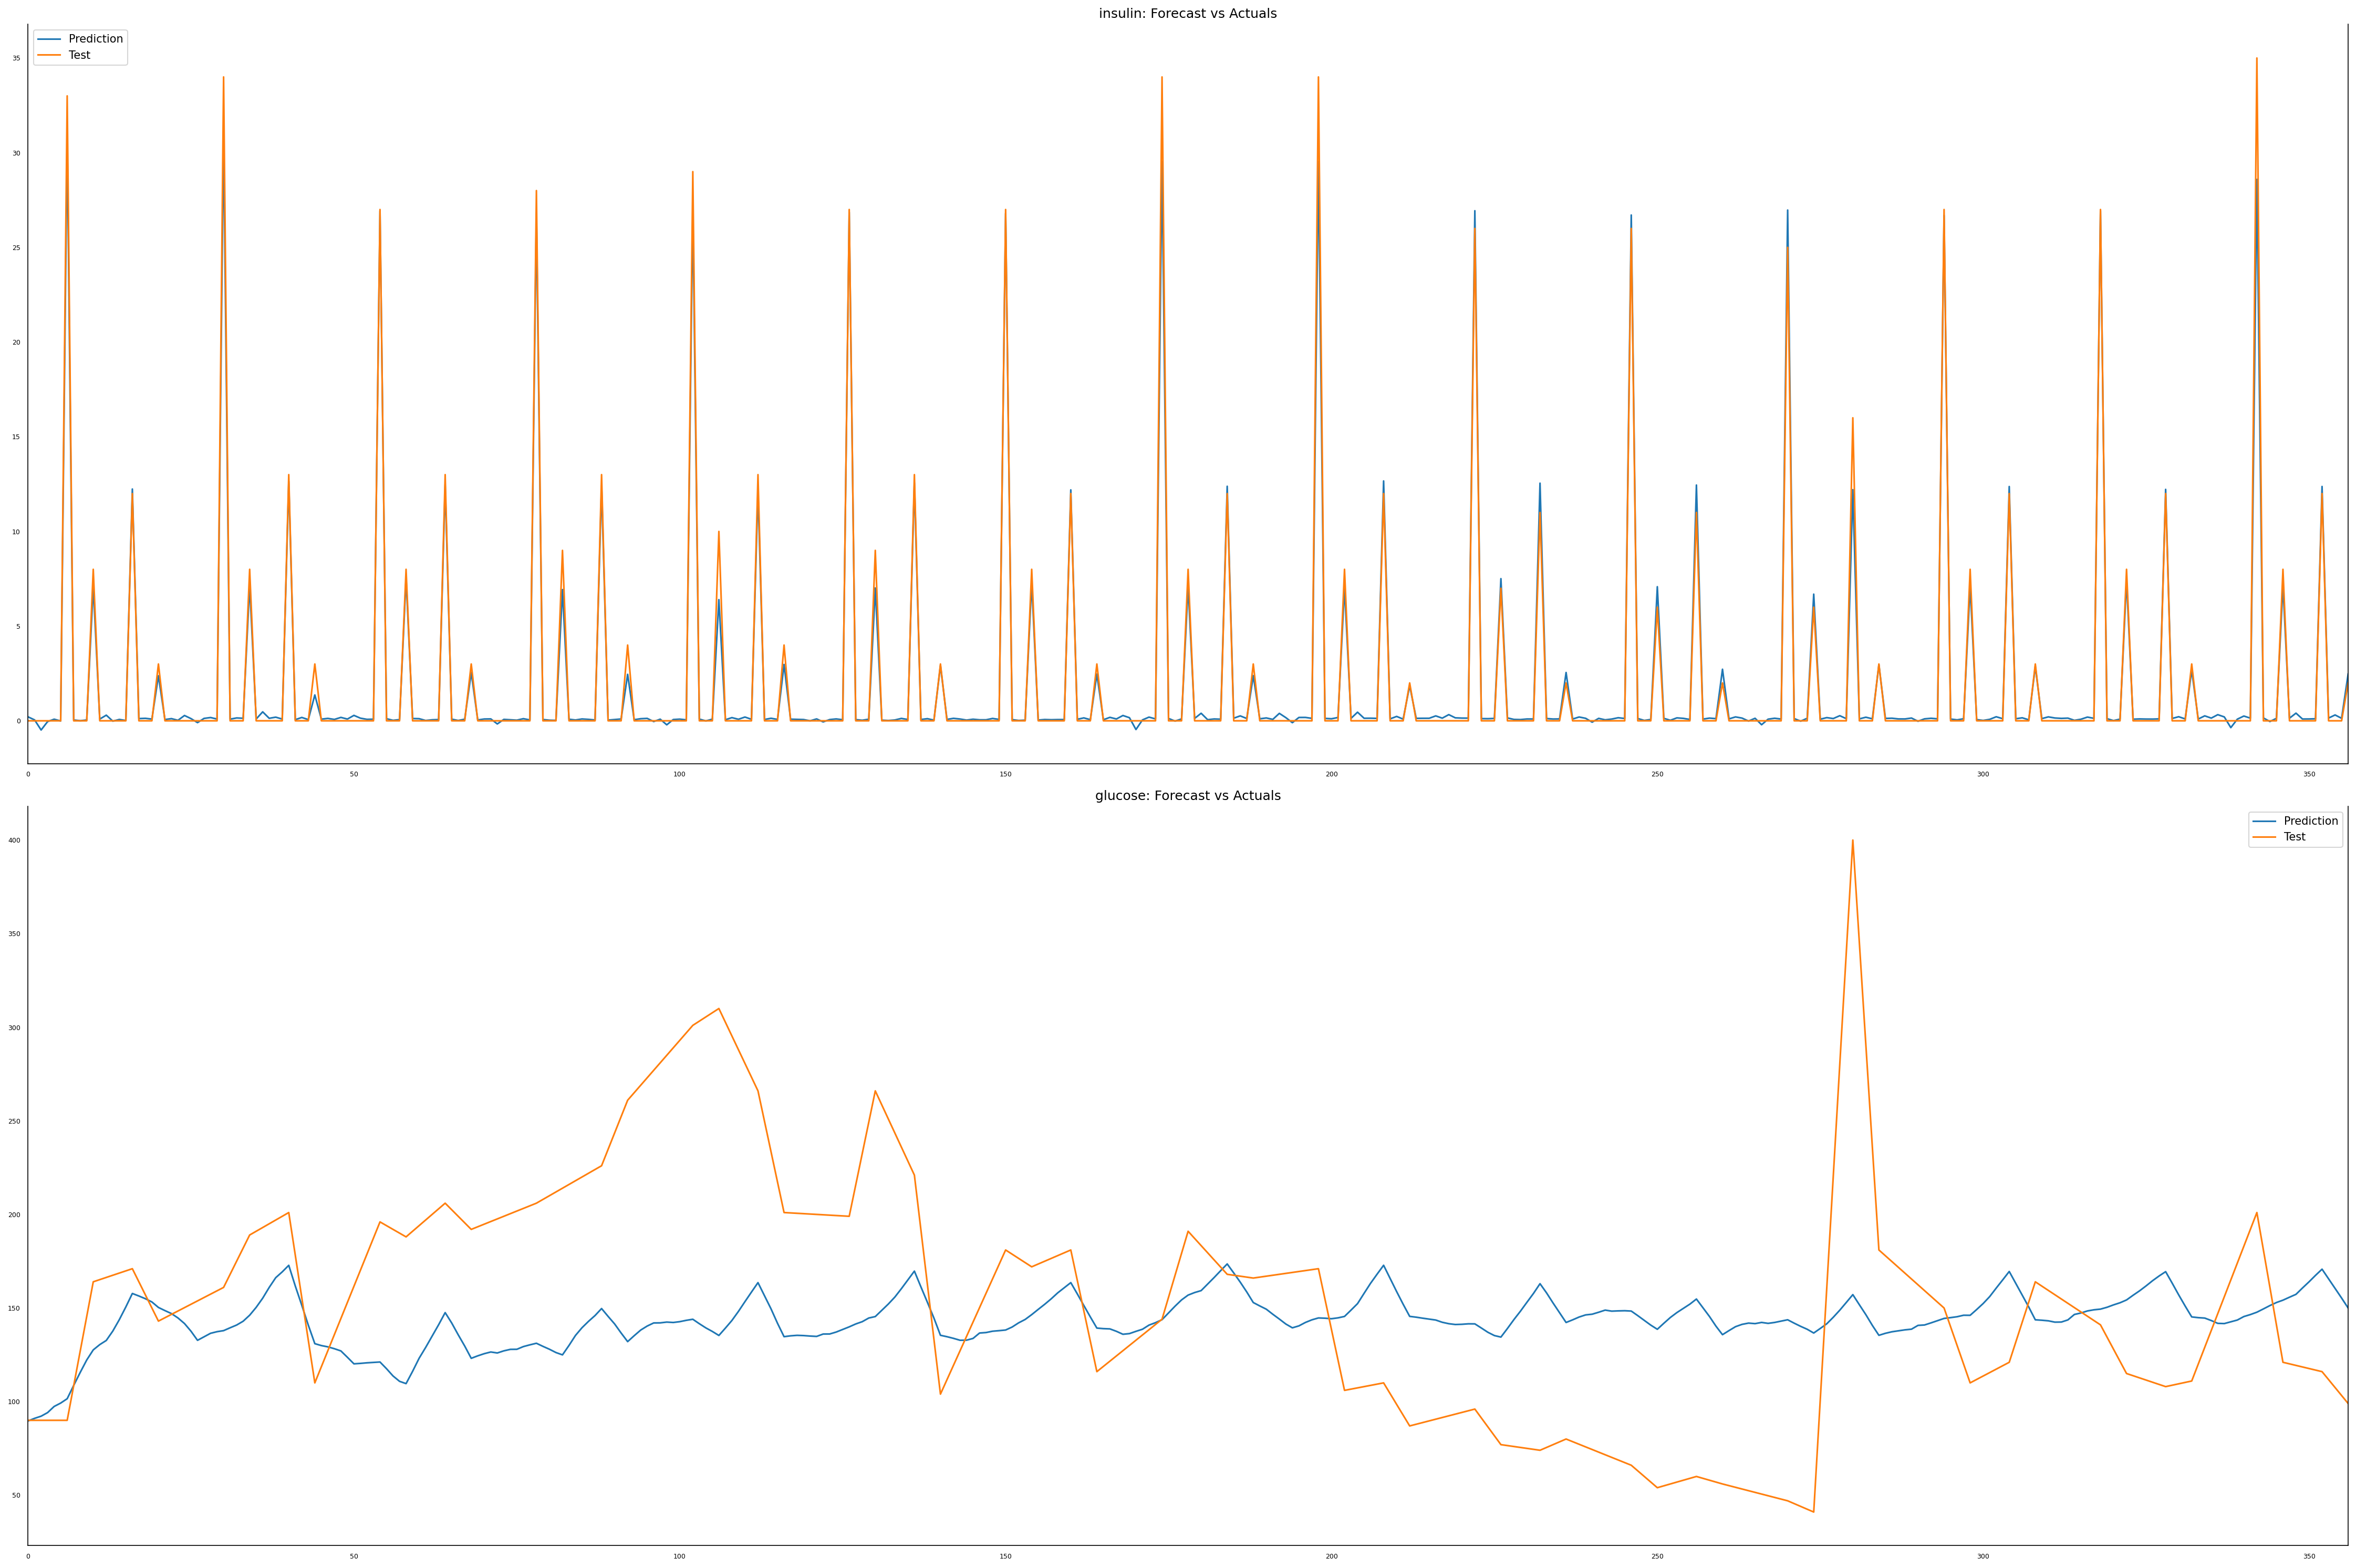

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=150, figsize=(30,20))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pd.Series(data=forecast[col].values, name="Prediction").plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    pd.Series(data=df_test[col].values, name="Test").plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
for col in df_test.columns:
    print(col)
    print("RMSE:", np.sqrt(mean_squared_error(df_test[col], forecast[col])))
    print("MAPE:", mean_absolute_percentage_error(df_test[col], forecast[col]))
    print("SMAPE:", calculate_smape(df_test[col], forecast[col]))
    print("MAE:", mean_absolute_error(df_test[col], forecast[col]))
    print("R^2:", r2_score(df_test[col], forecast[col]))

insulin
RMSE: 0.6882214523813877
MAPE: 428811783120702.5
SMAPE: 0.8423216153
MAE: 0.27889731333440143
R^2: 0.9885194852903284
glucose
RMSE: 66.03415757863775
MAPE: 0.41947936261686636
SMAPE: 0.1768147775
MAE: 52.14053204383536
R^2: -0.0827526869939108


Для первого ряда R^2 > 0.9, значит предсказание близко к истине

#### VARMA

In [109]:
pq = []
for name, column in df_train.items():
    print(f'Optimal p and q for {name}:')
    stepwise_model = auto_arima(data[name], start_p=1, start_q=1, max_p=7, max_q=7, seasonal=False,
        trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, maxiter=1000)
    params = stepwise_model.get_params().get('order')
    print(f'Best params for {name}: {params}')
    pq.append(params)

Optimal p and q for insulin:
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=24325.026, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=24321.026, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=24323.026, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=24323.026, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=23986.888, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=23954.008, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=23913.026, Time=0.40 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=23860.735, Time=0.79 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=23839.600, Time=0.67 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=23802.473, Time=0.78 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=23795.989, Time=1.08 sec
 ARIMA(7,0,0)(0,0,0)[0] intercept   : AIC=23750.380, Time=1.31 sec
 ARIMA(7,0,1)(0,0,0)[0] intercept   : AIC=23354.228, Time=8.69 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=23392.744, Time

In [110]:
model = VARMAX(df_train, order=(7, 3))
model_fitted = model.fit(disp=False)
model_fitted.summary()

C:\Users\Mensh\PycharmProjects\timeseries\.venv\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


LinAlgError: Schur decomposition solver error.

In [111]:
forecast = model_fitted.forecast(y=model_fitted.endog, steps=len(df_test))
forecast = pd.DataFrame(forecast, columns=[col for col in df_train.columns])

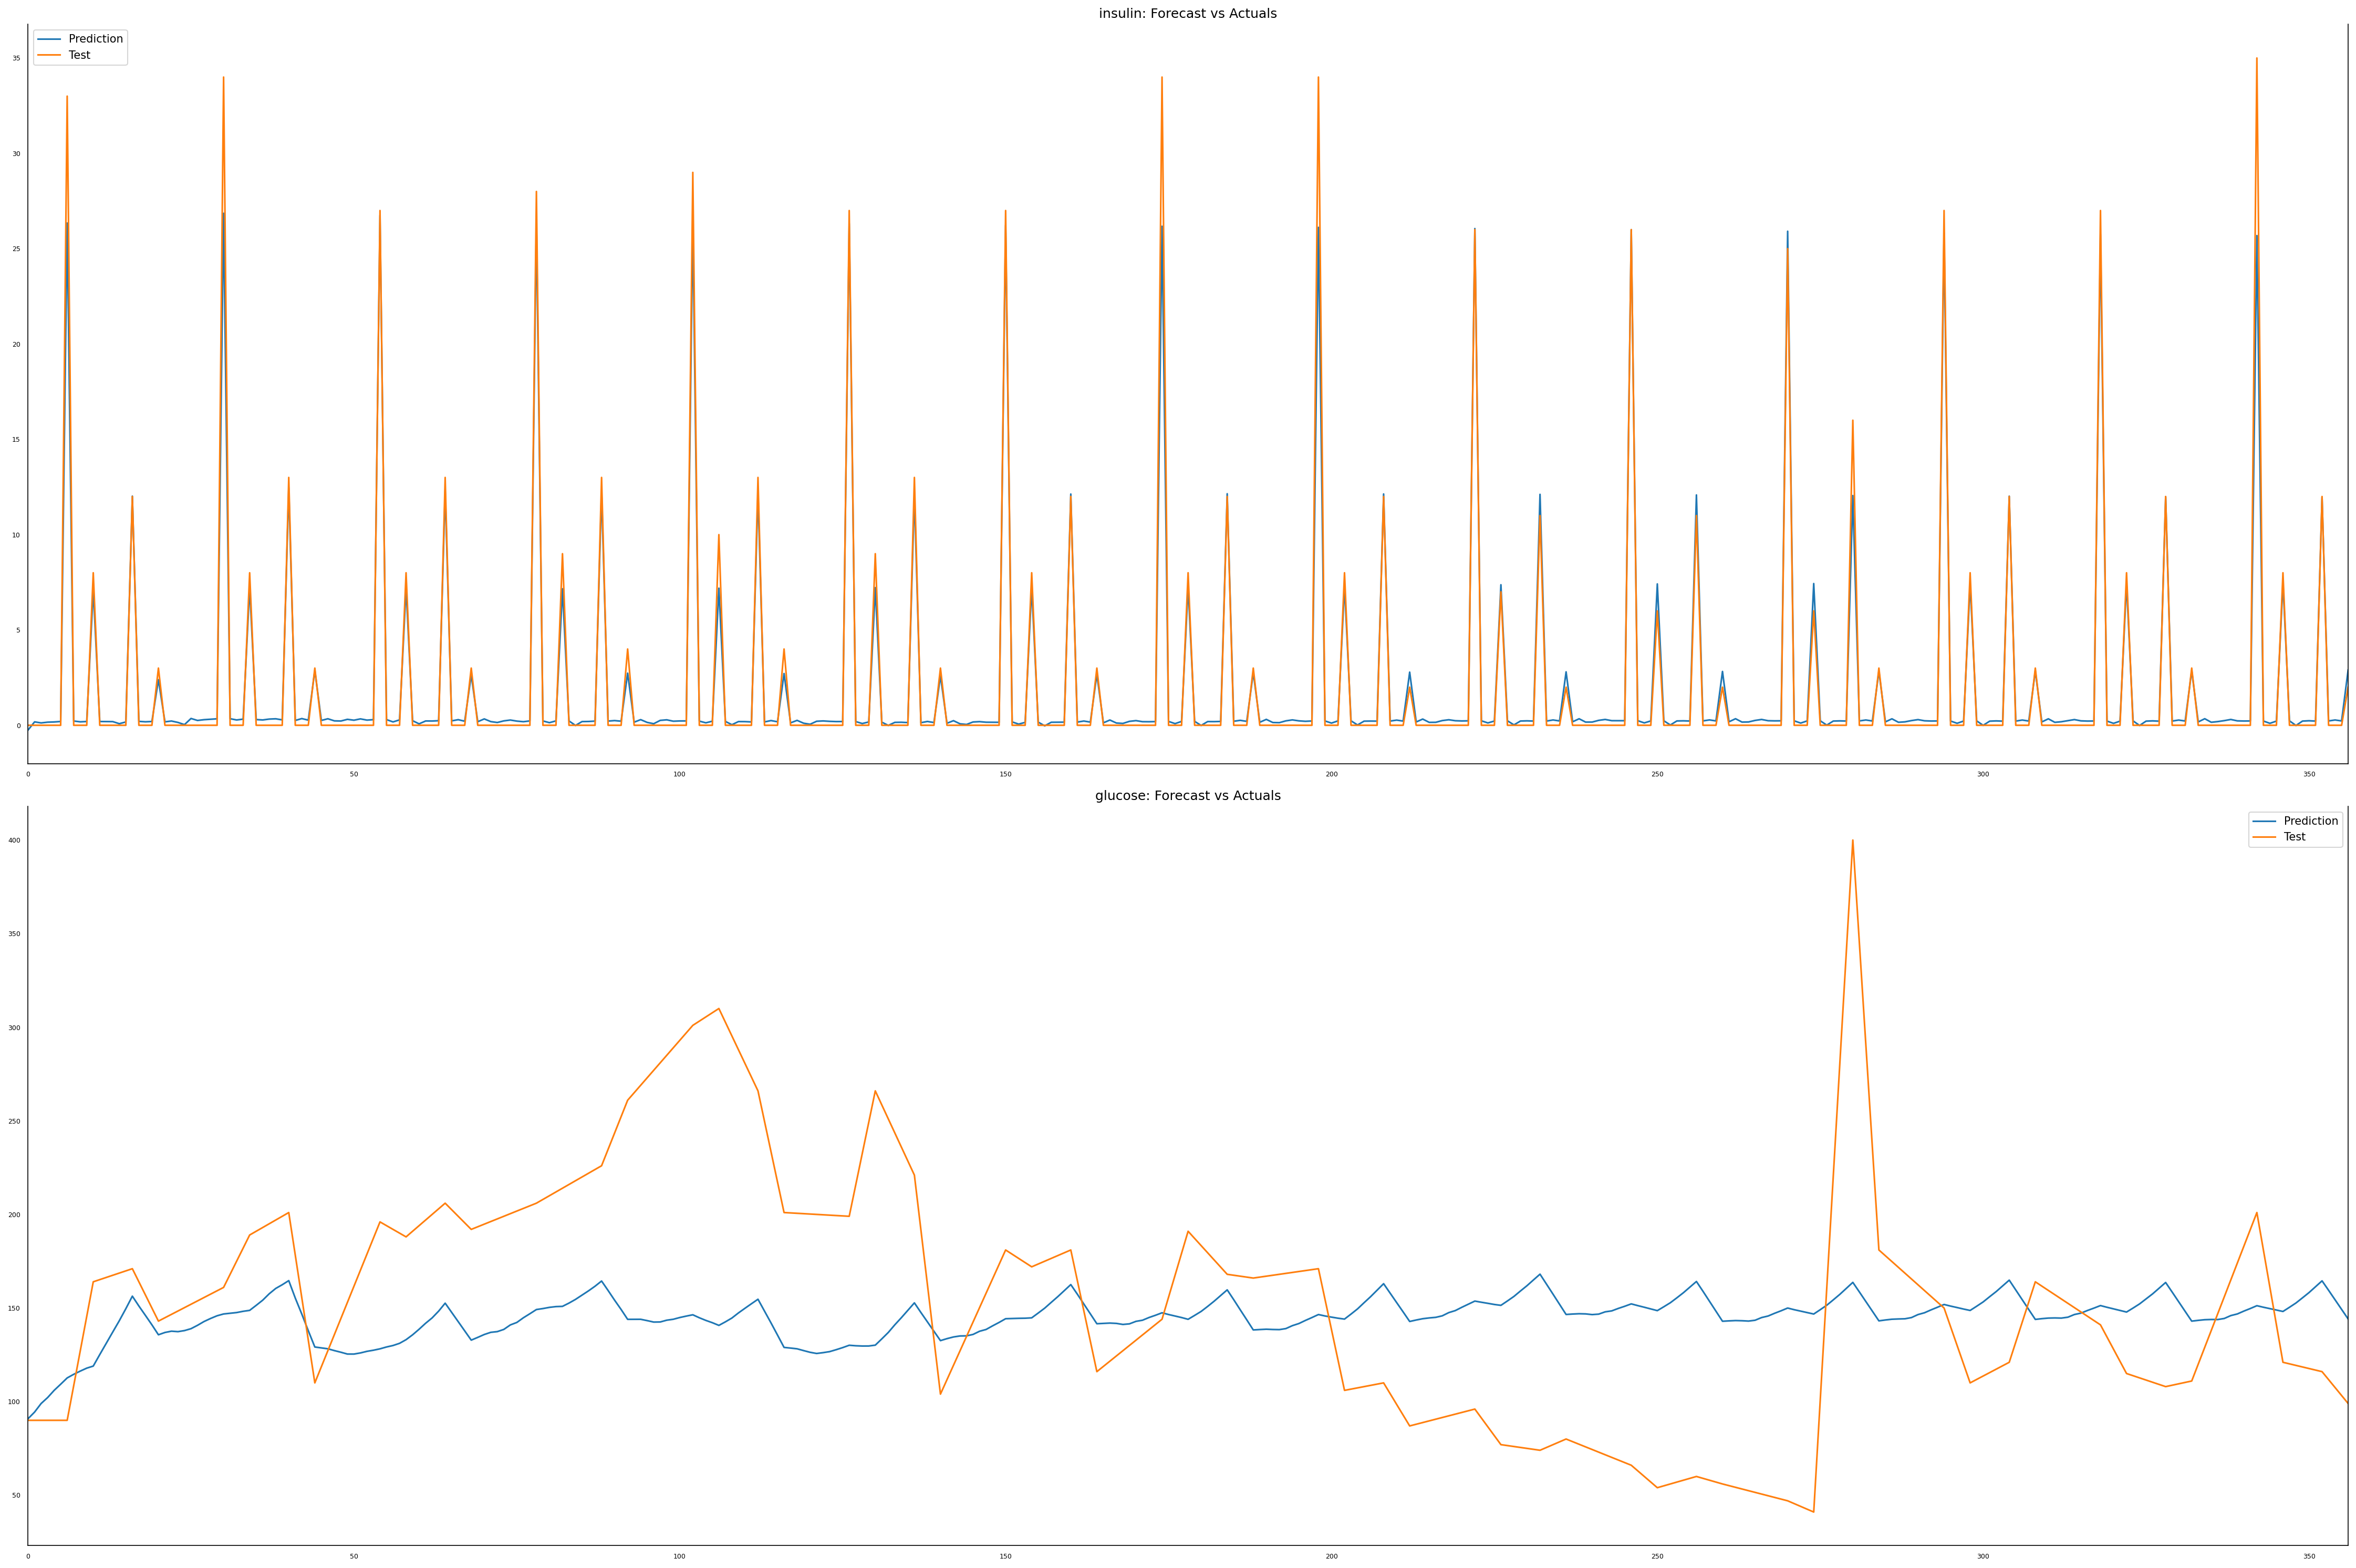

In [112]:
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=150, figsize=(30,20))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pd.Series(data=forecast[col].values, name="Prediction").plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    pd.Series(data=df_test[col].values, name="Test").plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [113]:
for col in df_test.columns:
    print(col)
    print("RMSE:", np.sqrt(mean_squared_error(df_test[col], forecast[col])))
    print("MAPE:", mean_absolute_percentage_error(df_test[col], forecast[col]))
    print("SMAPE:", calculate_smape(df_test[col], forecast[col]))
    print("MAE:", mean_absolute_error(df_test[col], forecast[col]))
    print("R^2:", r2_score(df_test[col], forecast[col]))

insulin
RMSE: 1.0373974851342465
MAPE: 774006881706619.8
SMAPE: 0.8424179125
MAE: 0.4025301142287558
R^2: 0.9739147304108923
glucose
RMSE: 65.7506352869887
MAPE: 0.430429690877093
SMAPE: 0.1765221821
MAE: 52.174186007052455
R^2: -0.07347489790605533


Для первого ряда R^2 > 0.9, значит предсказание близко к истине

Обе модели очень хорошо справились с предсказанием инсулина

## Нейронные сети

In [32]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:(i + lookback)]
        target = dataset[i + lookback]
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y)

def calculate_smape(actual, predicted):
    return round(np.mean(np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual))), 10)


### RNN

In [21]:
def build_RNN(npas, icol, hout):
    grid_model = Sequential()
    grid_model.add(SimpleRNN(hout, input_shape=(npas,icol)))
    grid_model.add(Dropout(0.05))
    grid_model.add(Dense(icol))

    grid_model.compile(loss = 'mse', optimizer = Adam(learning_rate=1e-5))
    return grid_model

In [25]:
npas = 128
icol = 2
hout = 128

rnn_model = build_RNN(npas, icol, hout)

data_train = df_train.copy()
data_test = df_test.copy()

scaler = MinMaxScaler(feature_range=(0,1))
data_train_ranged = scaler.fit_transform(data_train)
data_test_ranged = scaler.fit_transform(data_test)

X_train, y_train = create_dataset(data_train_ranged, lookback=npas)
X_test, y_test = create_dataset(data_test_ranged, lookback=npas)

rnn_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

prediction = rnn_model.predict(X_test)
y_test_reverse, prediction_reverse = scaler.inverse_transform(y_test), scaler.inverse_transform(prediction)

(3082, 128, 2) (3082, 2)
Epoch 1/100
49/49 [==============================] - 4s 39ms/step - loss: 0.1812
Epoch 2/100
49/49 [==============================] - 2s 36ms/step - loss: 0.0569
Epoch 3/100
49/49 [==============================] - 2s 38ms/step - loss: 0.0476
Epoch 4/100
49/49 [==============================] - 2s 39ms/step - loss: 0.0452
Epoch 5/100
49/49 [==============================] - 2s 38ms/step - loss: 0.0433
Epoch 6/100
49/49 [==============================] - 2s 38ms/step - loss: 0.0405
Epoch 7/100
49/49 [==============================] - 2s 39ms/step - loss: 0.0382
Epoch 8/100
49/49 [==============================] - 2s 41ms/step - loss: 0.0358
Epoch 9/100
49/49 [==============================] - 2s 38ms/step - loss: 0.0336
Epoch 10/100
49/49 [==============================] - 3s 51ms/step - loss: 0.0317
Epoch 11/100
49/49 [==============================] - 2s 41ms/step - loss: 0.0295
Epoch 12/100
49/49 [==============================] - 2s 43ms/step - loss: 0.0275


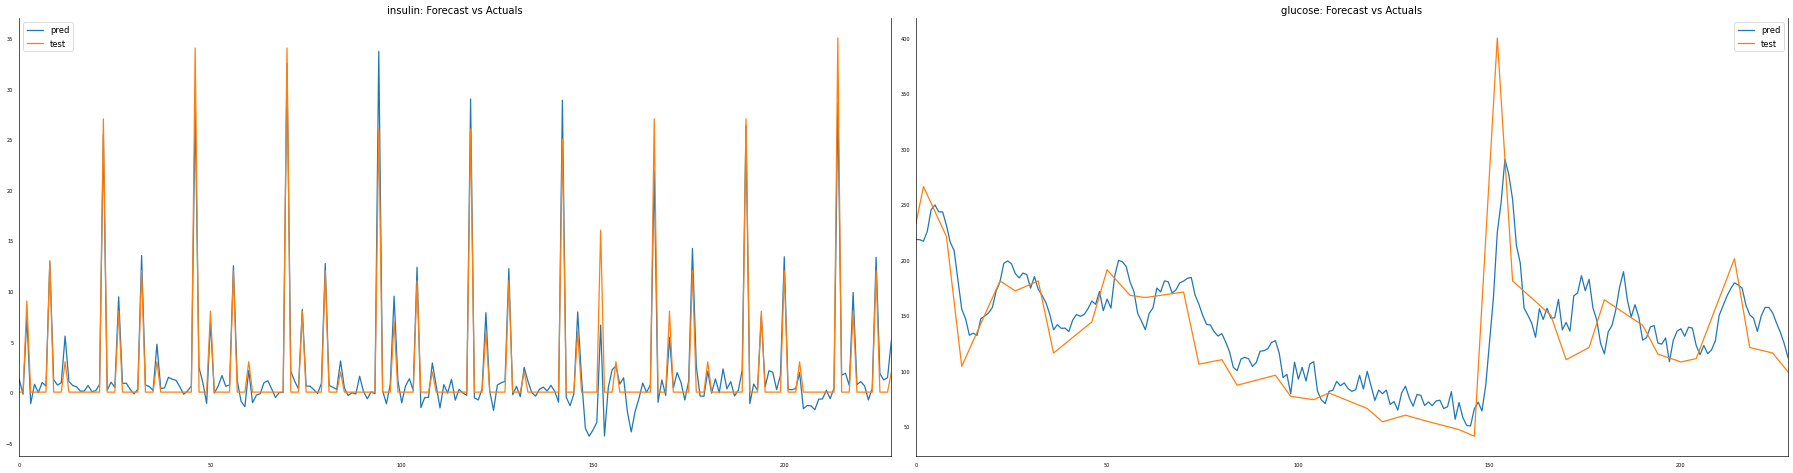

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(30,8))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pd.Series(data=prediction_reverse[:, i], name="Prediction").plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    pd.Series(data=y_test_reverse[:, i], name="Test").plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [28]:
for i in range(len(data_train.columns)):
    print(data_train.columns[i])
    print("RMSE:", np.sqrt(mean_squared_error(y_test_reverse[:, i], prediction_reverse[:, i])))
    print("MAPE:", mean_absolute_percentage_error(y_test_reverse[:, i], prediction_reverse[:, i]))
    print("SMAPE:", calculate_smape(y_test_reverse[:, i], prediction_reverse[:, i]))
    print("MAE:", mean_absolute_error(y_test_reverse[:, i], prediction_reverse[:, i]))
    print("R^2:", r2_score(y_test_reverse[:, i], prediction_reverse[:, i]))

insulin
RMSE: 1.6206082332478726
MAPE: 3214648559655422.0
SMAPE: 0.8495058941
MAE: 1.0789132576647285
R^2: 0.9320912572770428
glucose
RMSE: 32.713290089465644
MAPE: 0.19167497100159187
SMAPE: 0.0887749459
MAE: 22.650989181540766
R^2: 0.6684405188399238


Опираясь на графики и метрики, можно сказать, что оба параметра предсказаны с достаточно высокой точностью

### LSTM

In [25]:
def build_LSTM(npas, icol, hout):
    grid_model = Sequential()
    grid_model.add(LSTM(hout, input_shape=(npas,icol), activation='relu'))
    grid_model.add(Dropout(0.05))
    grid_model.add(Dense(icol + int((hout - icol) * 0.5)))
    grid_model.add(Dense(icol))

    grid_model.compile(loss = 'mse', optimizer = Adam(learning_rate=2e-4))
    return grid_model

In [34]:
npas = 128
icol = 2
hout = 32

lstm_model = build_LSTM(npas, icol, hout)

data_train = df_train.copy()
data_test = df_test.copy()

scaler = MinMaxScaler(feature_range=(0,1))
data_train_ranged = scaler.fit_transform(data_train)
data_test_ranged = scaler.fit_transform(data_test)

X_train, y_train = create_dataset(data_train_ranged, lookback=npas)
X_test, y_test = create_dataset(data_test_ranged, lookback=npas)

print(X_train.shape, y_train.shape)

lstm_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

prediction = lstm_model.predict(X_test)
y_test_reverse, prediction_reverse = scaler.inverse_transform(y_test), scaler.inverse_transform(prediction)

(3082, 128, 2) (3082, 2)
Epoch 1/100
49/49 [==============================] - 6s 56ms/step - loss: 0.0669
Epoch 2/100
49/49 [==============================] - 3s 57ms/step - loss: 0.0282
Epoch 3/100
49/49 [==============================] - 3s 55ms/step - loss: 0.0203
Epoch 4/100
49/49 [==============================] - 3s 59ms/step - loss: 0.0199
Epoch 5/100
49/49 [==============================] - 3s 56ms/step - loss: 0.0197
Epoch 6/100
49/49 [==============================] - 3s 54ms/step - loss: 0.0196
Epoch 7/100
49/49 [==============================] - 3s 61ms/step - loss: 0.0194
Epoch 8/100
49/49 [==============================] - 3s 59ms/step - loss: 0.0192
Epoch 9/100
49/49 [==============================] - 3s 63ms/step - loss: 0.0190
Epoch 10/100
49/49 [==============================] - 3s 56ms/step - loss: 0.0190
Epoch 11/100
49/49 [==============================] - 3s 53ms/step - loss: 0.0186
Epoch 12/100
49/49 [==============================] - 3s 60ms/step - loss: 0.0185


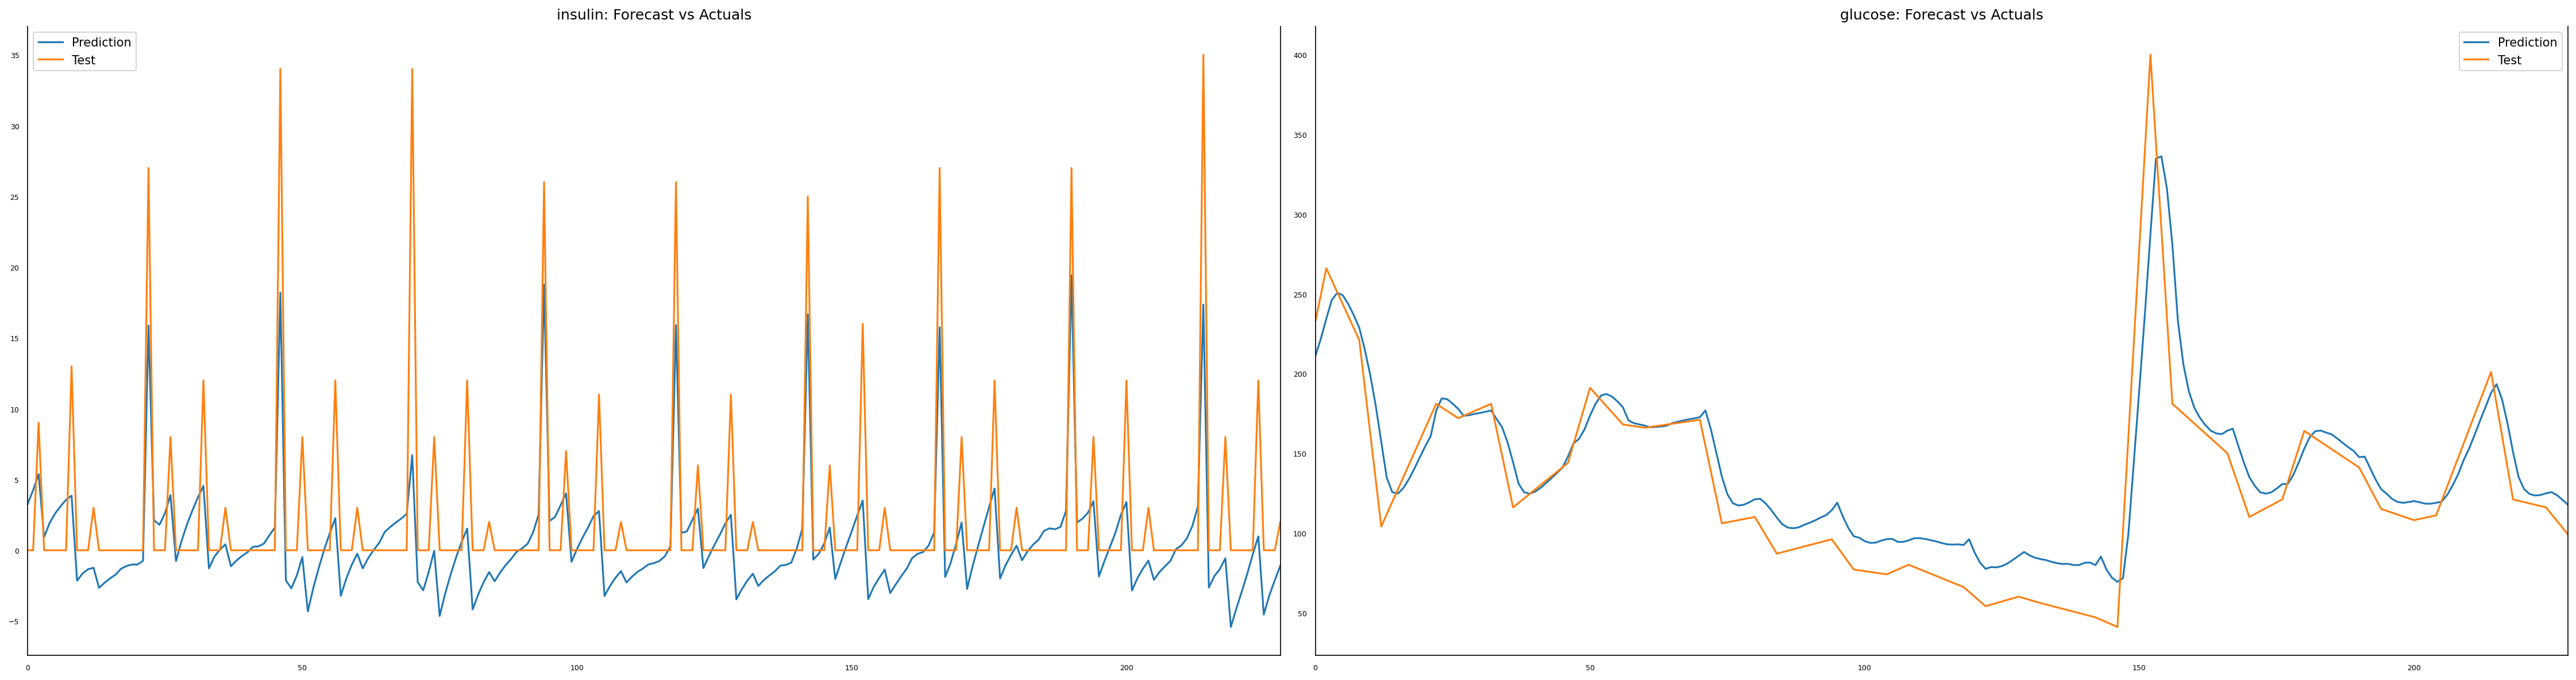

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(30,8))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pd.Series(data=prediction_reverse[:, i], name="Prediction").plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    pd.Series(data=y_test_reverse[:, i], name="Test").plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [36]:
for i in range(len(data_train.columns)):
    print(data_train.columns[i])
    print("RMSE:", np.sqrt(mean_squared_error(y_test_reverse[:, i], prediction_reverse[:, i])))
    print("MAPE:", mean_absolute_percentage_error(y_test_reverse[:, i], prediction_reverse[:, i]))
    print("SMAPE:", calculate_smape(y_test_reverse[:, i], prediction_reverse[:, i]))
    print("MAE:", mean_absolute_error(y_test_reverse[:, i], prediction_reverse[:, i]))
    print("R^2:", r2_score(y_test_reverse[:, i], prediction_reverse[:, i]))

insulin
RMSE: 4.133830653184233
MAPE: 6109344329124868.0
SMAPE: 0.9351181381
MAE: 2.658073772631553
R^2: 0.5581498867261641
glucose
RMSE: 23.879221311901787
MAPE: 0.1715517646181923
SMAPE: 0.0751855407
MAE: 17.05907313140025
R^2: 0.8233338589075024


Несмотря на многочисленные попытки получить приемлемый результат от данной модели, ее метрики для инсулина все еще намного хуже, чем у классических моделей.
Остается только процитировать классика: "Если лстм выдает результат хуже, чем arma, проблема не в лстм, а в той персоне, что сидела за клавиатурой и собирала эту несчастную лстм"

### GRU

In [39]:
def build_GRU(npas, icol, hout):
    grid_model = Sequential()
    grid_model.add(GRU(hout, input_shape=(npas,icol)))
    grid_model.add(Dropout(0.05))
    grid_model.add(Dense(icol))

    grid_model.compile(loss = 'mse', optimizer = Adam(learning_rate=1e-5))
    return grid_model

In [35]:
npas = 128
icol = 2
hout = 128

gru_model = build_GRU(npas, icol, hout)

data_train = df_train.copy()
data_test = df_test.copy()

scaler = MinMaxScaler(feature_range=(0,1))
data_train_ranged = scaler.fit_transform(data_train)
data_test_ranged = scaler.fit_transform(data_test)

X_train, y_train = create_dataset(data_train_ranged, lookback=npas)
X_test, y_test = create_dataset(data_test_ranged, lookback=npas)

print(X_train.shape, y_train.shape)

gru_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

prediction = gru_model.predict(X_test)
y_test_reverse, prediction_reverse = scaler.inverse_transform(y_test), scaler.inverse_transform(prediction)

(3082, 128, 2) (3082, 2)
Epoch 1/100
49/49 [==============================] - 4s 40ms/step - loss: 0.0496
Epoch 2/100
49/49 [==============================] - 2s 39ms/step - loss: 0.0357
Epoch 3/100
49/49 [==============================] - 2s 41ms/step - loss: 0.0338
Epoch 4/100
49/49 [==============================] - 2s 41ms/step - loss: 0.0327
Epoch 5/100
49/49 [==============================] - 2s 41ms/step - loss: 0.0303
Epoch 6/100
49/49 [==============================] - 2s 43ms/step - loss: 0.0290
Epoch 7/100
49/49 [==============================] - 2s 39ms/step - loss: 0.0268
Epoch 8/100
49/49 [==============================] - 2s 39ms/step - loss: 0.0259
Epoch 9/100
49/49 [==============================] - 2s 42ms/step - loss: 0.0240
Epoch 10/100
49/49 [==============================] - 2s 39ms/step - loss: 0.0225
Epoch 11/100
49/49 [==============================] - 2s 40ms/step - loss: 0.0203
Epoch 12/100
49/49 [==============================] - 2s 40ms/step - loss: 0.0187


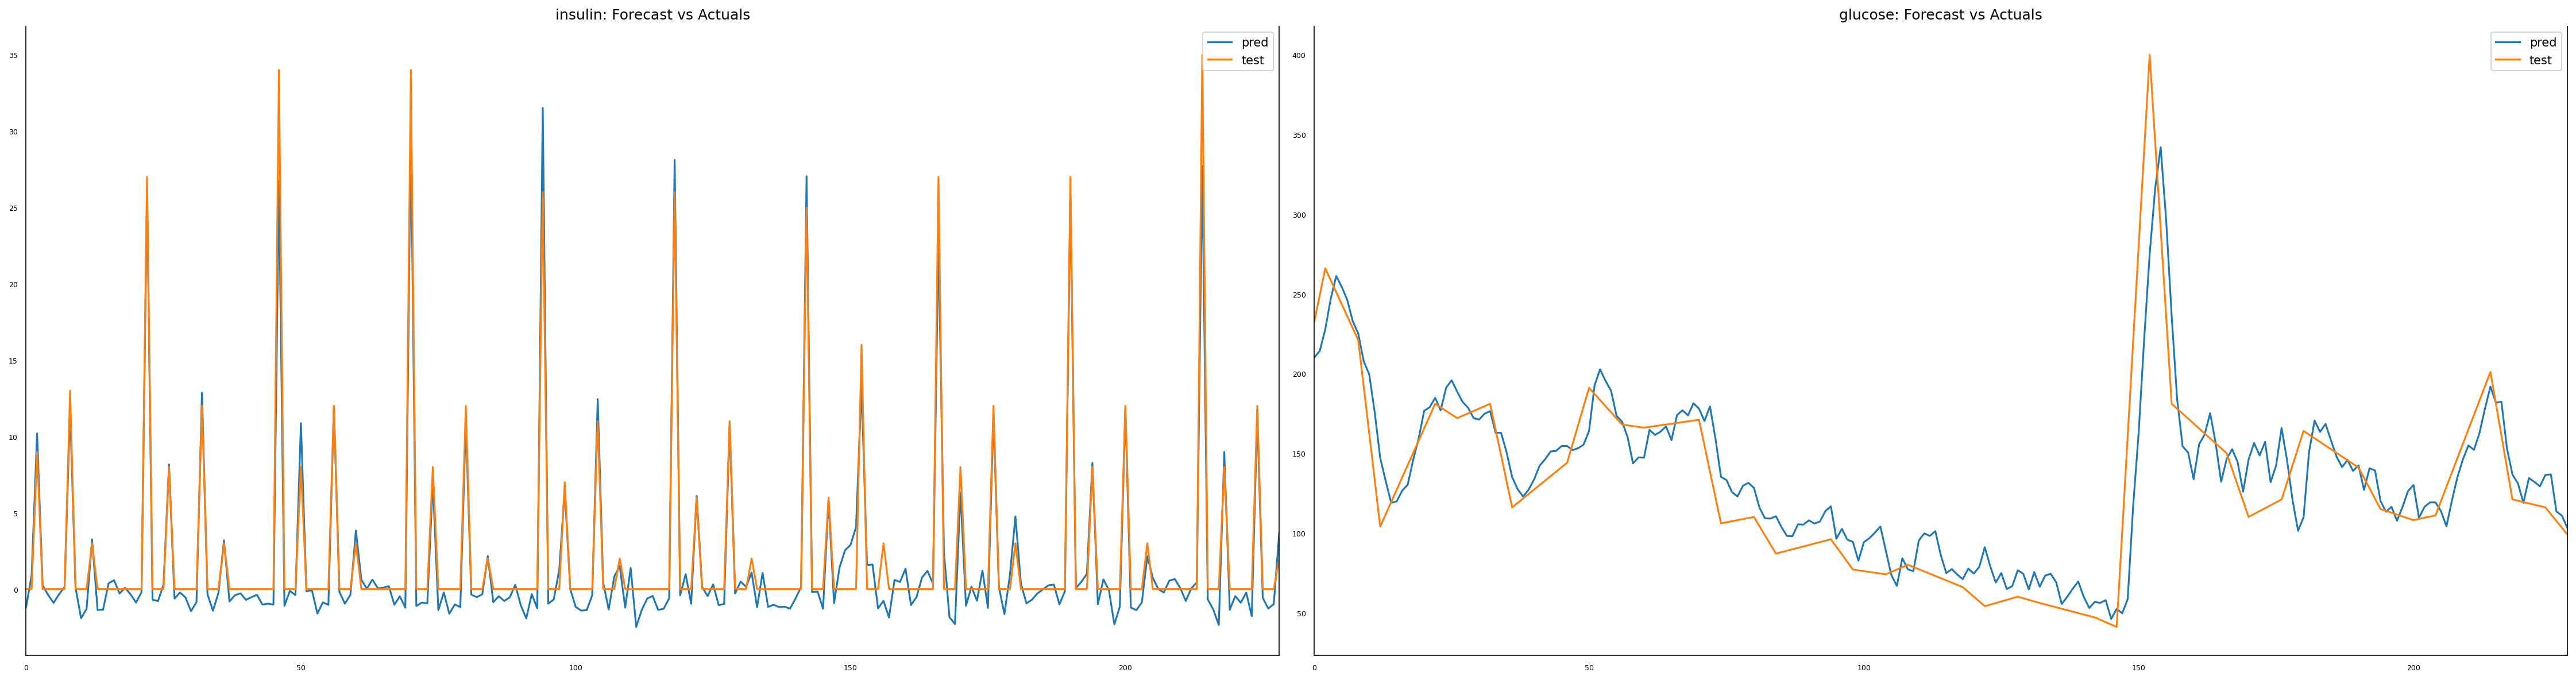

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(30,8))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pd.Series(data=prediction_reverse[:, i], name="Prediction").plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    pd.Series(data=y_test_reverse[:, i], name="Test").plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [37]:
for i in range(len(data_train.columns)):
    print(data_train.columns[i])
    print("RMSE:", np.sqrt(mean_squared_error(y_test_reverse[:, i], prediction_reverse[:, i])))
    print("MAPE:", mean_absolute_percentage_error(y_test_reverse[:, i], prediction_reverse[:, i]))
    print("SMAPE:", calculate_smape(y_test_reverse[:, i], prediction_reverse[:, i]))
    print("MAE:", mean_absolute_error(y_test_reverse[:, i], prediction_reverse[:, i]))
    print("R^2:", r2_score(y_test_reverse[:, i], prediction_reverse[:, i]))

insulin
RMSE: 1.376780081220923
MAPE: 3136791633338761.5
SMAPE: 0.8464475623
MAE: 0.970705969561111
R^2: 0.9509884140064568
glucose
RMSE: 25.015366001040633
MAPE: 0.1417122317067719
SMAPE: 0.0677965204
MAE: 16.886750712387773
R^2: 0.8061228064094587


Нейронные сети предсказали ряд намного лучше классических моделей, поэтому я отдал бы им предпочтение